**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [37]:
#install packages 
import math
import sympy as sp
from sympy import lambdify,symbols, ln, solve, sqrt
import scipy.optimize as opt
import numpy as np
import pandas as pd
from types import SimpleNamespace
import matplotlib.pyplot as plt
from matplotlib import cm #used for 3d plots
from scipy import optimize 
from scipy.optimize import minimize
import random
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [29]:
# 1 Define symbols
w, L,  tau, alpha, kappa, nu, G = symbols('w L tau alpha kappa nu G')
tilde_w = symbols(r'\tilde{w}')

# 2 Define tilde_w and private consumption function C

C = kappa + (1 - tau) * w * L

# 3 Define the utility function V
V = ln(C**alpha * G**(1 - alpha)) - nu * L**2 / 2

# 4 Compute the derivative of V with respect to L
dVdL = V.diff(L)

# 5 Substitute the relationship between tilde_w and C into dVdL
dVdL_substituted = dVdL.subs({C: kappa + (1 - tau) * w * L, w: tilde_w / (1 - tau)})

# 6 Solve the equation dVdL_substituted = 0 for L
optimal_L_expr = solve(dVdL_substituted, L)
optimal_L = optimal_L_expr[0]

# 7 Print the result
optimal_L


(-kappa*nu - sqrt(nu*(4*\tilde{w}**2*alpha + kappa**2*nu)))/(2*\tilde{w}*nu)

After simplification, it is the same as the formula required to prove which is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$,the optimal labour supply is indepent with government consumption acrroding to the optimal labor supply choice function.

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

In [30]:
# 1 set the parameter 
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
tau = 0.3
G_values = [1.0, 2.0]

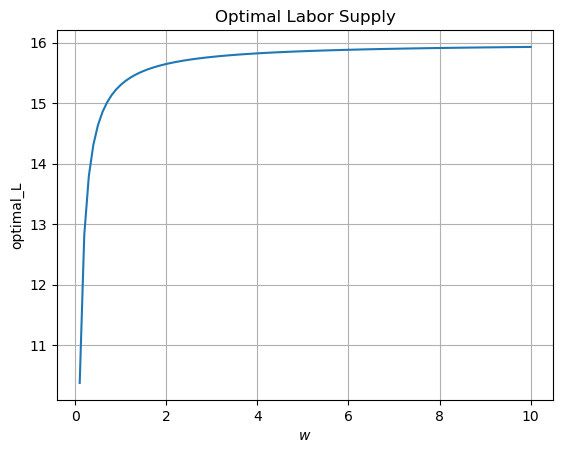

In [31]:
# 2 Define the symbol and expression for w
tilde_w = (1 - tau) * w

# 3 Define the expression for optimal_L rather than unsimplfied optimal_L
optimal_L_expr = (-kappa + sqrt(kappa**2 + 4 * alpha * tilde_w**2 / nu)) / (2 * tilde_w)

# 4 Lambdify the expression for optimal_L
optimal_L_func = lambdify(w, optimal_L_expr)

# 5 Define the range of w values
w_values = np.linspace(0.1, 10, 100)  # Adjust the range as needed

# 6 Compute the corresponding optimal_L values
L_star_values = [optimal_L_func(w_val) for w_val in w_values]

# 7 Plot the relationship between w and L_star
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(w_values, L_star_values)
ax.set_title('Optimal Labor Supply')
ax.set_xlabel('$w$')
ax.set_ylabel('optimal_L')
ax.grid(True)



We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


$\tau \in (0,1)$ is the labor-income tax rate. So we build the function of optimal labor supply, government consumption and worker ulility function: $L_C$, $G_C$ and $V_C$, and then plot how they change acrroding different value of $\tau \in (0,1)$.


In [32]:
# 1 set gover_consumption depend on tau value
def gover_consumption(tau_g,w=1):
    L_C = (-kappa + sqrt(kappa**2 + 4 * alpha * ((1 - tau_g) * w)**2 / nu)) / (2 * ((1 - tau_g) * w))
    G_C = tau_g * w * L_C
    V_C = ln((kappa + (1 - tau_g) * w * L_C**alpha * G_C)**(1 - alpha)) - nu * L_C**2 / 2
    return L_C,G_C,V_C

Text(0.5, 1.0, 'Government Consumption')

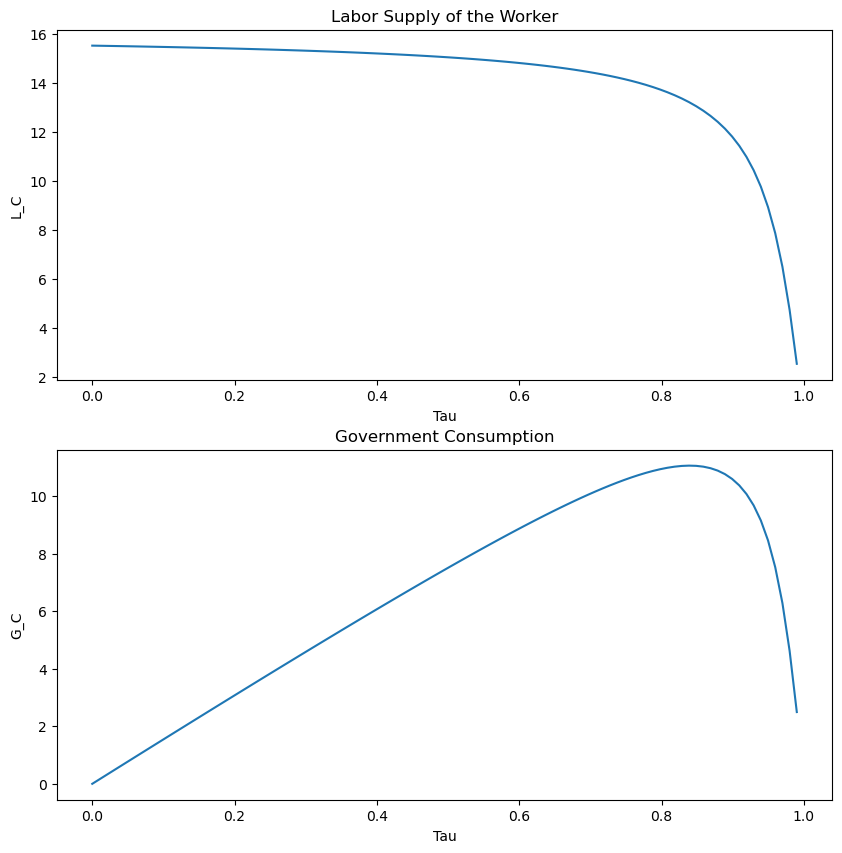

In [33]:
# 2 Define the range of tau values
tau_values = np.linspace(0, 1, 100)  # Adjust the number of points as desired

# 3 Initialize arrays to store the calculated values
L_C_values = np.zeros_like(tau_values)
G_C_values = np.zeros_like(tau_values)
V_C_values = np.zeros_like(tau_values)


# 4 Calculate the values for each tau
for i, tau in enumerate(tau_values):
    L_C, G_C, V_C = gover_consumption(tau,w=1)
    L_C_values[i] = L_C
    G_C_values[i] = G_C
    V_C_values[i] = V_C
    

# 5 Plot the results
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
ax.plot(tau_values, L_C_values)
ax.set_xlabel('Tau')
ax.set_ylabel('L_C')
ax.set_title('Labor Supply of the Worker')

ax = plt.subplot(2, 1, 2)
ax.plot(tau_values, G_C_values)
ax.set_xlabel('Tau')
ax.set_ylabel('G_C')
ax.set_title('Government Consumption')

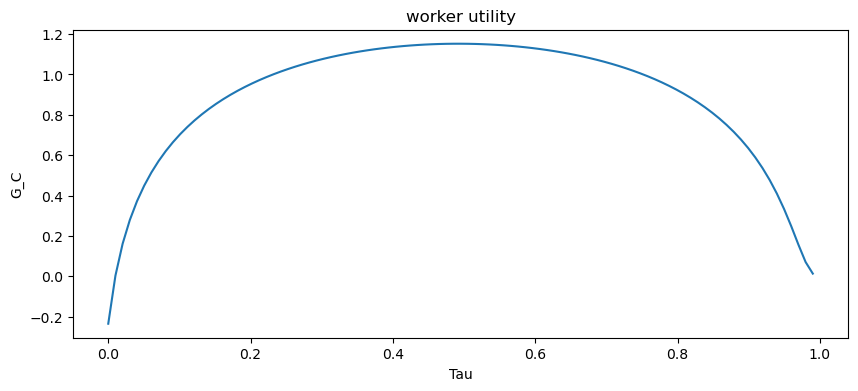

In [34]:
# 5 Plot the result for worker utility 
plt.figure(figsize=(10, 4))
plt.subplot(1, 1, 1)
plt.plot(tau_values, V_C_values)
plt.xlabel('Tau')
plt.ylabel('G_C')
plt.title('worker utility')


plt.show()

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

From the answers of Question 3, we can guess the $\tau$ value maximizing worker utility is near 0.5.

In [35]:
# 1 set the function of worker utility
def objective_function(tau_g):
    L_C, G_C, V_C = gover_consumption(float(tau_g), w=1)
    return -V_C


In [41]:
# 2 Perform the optimization
result = minimize(objective_function, x0=[0.5], method='Nelder-Mead', bounds=[(0, 1)])

# 3 Extract the maximum V_C and corresponding tau_g
max_V_C = -result.fun
optimal_tau_g = result.x[0]

# 4 Print the maximum V_C and corresponding tau_g
print("Maximum V_C:", max_V_C)
print("Optimal tau_g:", optimal_tau_g)

TypeError: Cannot convert expression to float

The result of $\tau$ value maximizing worker utility is 0.4916015625 near 0.5, it verify our guess. But under this value, the government consumption has not reach the maximazition according to  Question 3. For the socially optimal tax rate, the government should refrain from raising taxes. This means that the optimal tax rate that maximises worker utility may contradict the tax rate that maximises government consumption when government consumption is taken into account.

Maximising worker utility may imply setting a tax rate that allows workers to retain a larger proportion of their income, thereby maximising their satisfaction and well-being. On the other hand, maximising government consumption may require a higher tax rate in order to obtain more tax revenue for public expenditure, investment in public goods and services.

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [42]:
# 1 find the optimal labor supply function 
import sympy as sp
w, L,  tau, alpha, kappa, nu, G = symbols('w L tau alpha kappa nu G')
rho, epsilon, sigma = sp.symbols('rho epsilon sigma')
tilde_w = symbols(r'\tilde{w}')

C = kappa + (1 - tau) * w * L
V = (((alpha * C**((sigma - 1) / sigma) + (1 - alpha) * G**((sigma - 1) / sigma))**(sigma / (sigma-1)))**(1 - rho) - 1) / (1 - rho) - nu * L**(1 + epsilon) / (1 + epsilon)

dV_dL = sp.diff(V, L)

equation = dV_dL.subs(C, kappa + (1 - tau) * w * L)
simplified_equation = sp.simplify(equation)

optimal_L_new = sp.solve(simplified_equation, L)
optimal_L_new_func = optimal_L_new[0].subs(w, tilde_w / (1 - tau))


KeyboardInterrupt: 

In [39]:
# 1 find the optimal labor supply function 

w, L,  tau, alpha, kappa, nu, G = sp.symbols('w L tau alpha kappa nu G')
rho, epsilon, sigma = sp.symbols('rho epsilon sigma')
tilde_w = sp.symbols(r'\tilde{w}')

C = kappa + (1 - tau) * w * L
V = (((alpha * C**((sigma - 1) / sigma) + (1 - alpha) * G**((sigma - 1) / sigma))**(sigma / (sigma-1)))**(1 - rho) - 1) / (1 - rho) - nu * L**(1 + epsilon) / (1 + epsilon)

dV_dL = sp.diff(V, L)

equation = dV_dL.subs(C, kappa + (1 - tau) * w * L)
simplified_equation = sp.simplify(equation)

optimal_L_new = sp.solve(simplified_equation, L)
optimal_L_new_func = optimal_L_new[0].subs(w, tilde_w / (1 - tau))

The step 1 can not have result so we use alternative step, the equation is from step 1. The formula is as followed, it is not perfect but maybe can be used to sole the question.

In [19]:
# 2 alternative step to find optimal labor supply function
equation = L*alpha*w*(tau - 1)*(-L*w*(tau - 1) + kappa)**((sigma - 1)/sigma)*((-G**((sigma - 1)/sigma)*(alpha - 1) + alpha*(-L*w*(tau - 1) + kappa)**((sigma - 1)/sigma))**(-sigma/(sigma - 1)))**(1 - rho) - L**(epsilon + 1)*nu*(G**((sigma - 1)/sigma)*(alpha - 1) - alpha*(-L*w*(tau - 1) + kappa)**((sigma - 1)/sigma))*(L*w*(tau - 1) - kappa) - L
simplified_equation = sp.simplify(equation)
print(simplified_equation)

L*alpha*w*(tau - 1)*(-L*w*(tau - 1) + kappa)**((sigma - 1)/sigma)*((-G**((sigma - 1)/sigma)*(alpha - 1) + alpha*(-L*w*(tau - 1) + kappa)**((sigma - 1)/sigma))**(-sigma/(sigma - 1)))**(1 - rho) - L - L**(epsilon + 1)*nu*(G**((sigma - 1)/sigma)*(alpha - 1) - alpha*(-L*w*(tau - 1) + kappa)**((sigma - 1)/sigma))*(L*w*(tau - 1) - kappa)


$$
\begin{align*}
& L \cdot \alpha \cdot w \cdot (\tau - 1) \cdot (-L \cdot w \cdot (\tau - 1) + \kappa)^{\frac{{\sigma - 1}}{{\sigma}}} \cdot \left( -G^{\frac{{\sigma - 1}}{{\sigma}}} \cdot (\alpha - 1) + \alpha \cdot (-L \cdot w \cdot (\tau - 1) + \kappa)^{\frac{{\sigma - 1}}{{\sigma}}} \right)^{-\frac{{\sigma}}{{\sigma - 1}}} \\
& - L - L^{(\epsilon + 1)} \cdot \nu \cdot (G^{\frac{{\sigma - 1}}{{\sigma}}} \cdot (\alpha - 1) - \alpha \cdot (-L \cdot w \cdot (\tau - 1) + \kappa)^{\frac{{\sigma - 1}}{{\sigma}}}) \cdot (L \cdot w \cdot (\tau - 1) - \kappa) = 0
\end{align*}
$$

In [20]:
# 3 use optimal_L_new_func_to_getG to get G_value
def optimal_L_new_func_to_getG(G, w=1, tau=optimal_tau_g, sigma=1.001, rho=1.001, epsilon=1):
    L_N = simplified_equation
    return L_N

def G_value(G, w=1, tau=optimal_tau_g, sigma=1.001, rho=1.001, epsilon=1):
    G_N = tau * w * optimal_L_new_func_to_getG
    return G_N


NameError: name 'optimal_tau_g' is not defined

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [73]:
# 1 set the function of worker utility
def government_consumption_new(tau_n):
    L_N = optimal_L_new_func_to_getG
    G_N = G_value
    V_N = (((alpha * (kappa + (1 - tau) * w * L_N)**((sigma - 1) / sigma) + (1 - alpha) * G_N**((sigma - 1) / sigma))**(sigma / (1 - sigma)))**(1 - rho) - 1) / (1 - rho) - nu * L**(1 + epsilon) / (1 + epsilon)
    return L_N, G_N,V_N

def objective_function_new(tau_n):
    L_N, G_N,V_N = government_consumption_new(tau_n)
    return -V_N

# 2 Perform the optimization
result = minimize(objective_function_new, x0=[0.5], method='Nelder-Mead', bounds=[(0, 1)])

# 3 Extract the maximum V_C and corresponding tau_g
max_V_C = -result.fun
optimal_tau_n = result.x[0]

# 4 Print the maximum V_C and corresponding tau_g
print("Optimal tau_g:", optimal_tau_n)


TypeError: unsupported operand type(s) for *: 'Mul' and 'function'

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [12]:
par = SimpleNamespace()

# Baseline parameters
par.eta = 0.5   # Elasticity of demand
par.w = 1.0     # Wages

# Lamda functions for the given equations
y = lambda l : l                                                          # Amount of haircuts y = l
price = lambda  y : par.k * (y ** - par.eta)                                      # Price function
profits1 = lambda l : price(y(l)) * y(l) - par.w * (l ** (1 - par.eta)) - par.w * l   # Profit function 1
profits2 = lambda  l : par.k * (l ** (1 - par.eta)) - par.w * l                       # Profit function 2


l_test = lambda kap : (((1 - par.eta) * kap) / par.w) ** (1 / par.eta)     # Lamda function to check maximizing l from the model

# Define kappa within given set, the code is set up such that this array can be changed
par.kappa = [1.0 , 2.0]

# Define arrays, where we will store the results of  the numerical analysis and the models prediction for l which maximizes profit
opt = []   # Array with numerically calculated optimal l values
check = [] # Array with l values found via theoretical model

# Define the function we want to minimize, setting negative profits to maximize actual profits
def Objective(l):
    return -profits2(l)

x0 = 1.0 # Initial guess for optimization function

bounds = [(0.0 , None)] # Bounds for l; we cannot hire less than 0 hairdressers, 
# Fractions might be argued as possible where hairdressers might not be working full-time


# Loop for calculation and storage of results
for k in par.kappa:
    par.k = k
    res = optimize.minimize(Objective , x0 , method='SLSQP', bounds=bounds)
    check.append(l_test(k))
    opt.append(res.x[0])

# Loop to print out the collected data
# while this could be included in the previous loop, having a different loop for the printout allows for the possibility of editing the data
for i in range(len(par.kappa)):
    print ('\nFor kappa = %.1f:\n Numerical calculation:\n  l = %.2f , profits = %.2f\n With model solution:\n  l = %.2f , profits = %.2f'% ( par.kappa[i] , opt[i] , profits2(opt[i]) , check[i] , profits2(check[i])))



For kappa = 1.0:
 Numerical calculation:
  l = 0.25 , profits = 0.75
 With model solution:
  l = 0.25 , profits = 0.75

For kappa = 2.0:
 Numerical calculation:
  l = 1.00 , profits = 1.00
 With model solution:
  l = 1.00 , profits = 1.00


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [13]:
# Given baseline parameters
par.rho = 0.90
par.lota = 0.01
par.sigma = 0.10
par.R = (1 + 0.01) ** (1 / 12)

# Initiate arrays 
par.k_array = np.empty(121)       # Array for shock
par.k_log_array = np.empty(121)   # Array for shock
par.l_array = np.empty(121)       # Array for employees
par.e_array = np.empty(121)       # Array for error
par.profit_array = np.empty(121)  # Array for profits
# At t = 0
par.k_array[0] = 1                        # Initial shock
par.k_log_array[0] = math.log(par.k_array[0]) # Initial log for shock
par.l_array[0] = 0                        # Initial employees
par.e_array[0] = 0                        # Initial error
par.profit_array[0] = 0

par.t_array = list(range(0,120)) # array for time periods t = { 0 , 1 , ... , 119}

par.p = 1
par.K = 10

def solve_next_period(par):

    par.e_array[par.p] = np.random.normal(loc = -0.5 * (par.sigma ** 2) , scale = par.sigma)
    par.k_log_array[par.p] =  par.rho * par.k_log_array[par.p - 1] + par.e_array[par.p - 1]
    par.k_array[par.p] = math.e ** par.k_log_array[par.p]
    par.k = par.k_array[par.p]
    par.l_array[par.p] = (((1 - par.rho) * par.k_array[par.p]) / par.w) ** (1 - par.rho)
    par.profit_array[par.p] = profits2(par.l_array[par.p])
        
    return

def h_function1(i):
    if (par.l_array[i]==par.l_array[i-1]):
        c = par.lota
    else:
        c = 0

    return (par.R ** -i * par.k_array[par.p] * (par.l_array[par.p] ** (1 - par.rho)) - par.w * par.l_array[par.p] - c)

def h_function2(par):
    sum_h = 0
    for i in par.t_array:
        solve_next_period(par)
        sum_h += h_function1(i)
        par.p = i + 1
        
    return sum_h

def H_function(K):
    H = 0
    k_vec = list(range(0 , K))
    for k in k_vec:
        H += h_function2(par)
        
    return  (H / K)

# Select K:
par.shock = 10
ex_ante = H_function(par.shock)

tot_profit = 0
for i in par.t_array:
    tot_profit += par.profit_array[i]
avg = tot_profit/120
print('H = %.2f' % (ex_ante))



H = 19.97


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [43]:
par.delta = 0.05

l_star = lambda k : ((1 - par.rho) * k / par.w ) ** (1 / par.rho)

# Copy of previous functions with addition:
def solve_next_period_2(par):

    par.e_array[par.p] = np.random.normal(loc = -0.5 * (par.sigma ** 2) , scale = par.sigma)
    par.k_log_array[par.p] =  par.rho * par.k_log_array[par.p - 1] + par.e_array[par.p - 1]
    par.k_array[par.p] = math.e ** par.k_log_array[par.p]
    par.k = par.k_array[par.p]
    if(abs((par.l_array[par.p-1] - l_star(par.k_array[par.p]))) > par.delta):
        par.l_array[par.p] = l_star(par.k_array[par.p])
    else: 
        par.l_array[par.p] = par.l_array[par.p-1]
    par.l_array[par.p] = (((1 - par.rho) * par.k_array[par.p]) / par.w) ** (1 - par.rho)
    par.profit_array[par.p] = profits2(par.l_array[par.p])

    return

def h_function2(par):
    sum_h = 0
    for i in par.t_array:
        solve_next_period_2(par)
        sum_h += h_function1(i)
        par.p = i + 1
        
    return sum_h

def H_function2(K):
    H = 0
    k_vec = list(range(0 , K))
    for k in k_vec:
        H += h_function2(par)
        
    return  (H / K)

ex_ante2 = H_function2(par.shock)

tot_profit2 = 0
for i in par.t_array:
    tot_profit2 += par.profit_array[i]
avg2 = tot_profit2/120
print('H = %.2f' % (ex_ante2))


H = 13.55


No the new policy decreases the value of the Hairdressershop to 13.55. Hence the policy does not improve porfitability.  

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [16]:
def Opt_delta(x):
    par.delta = x

    H = H_function2(par.shock)

    return - H

# guess_delta = 0.02
# bounds_delta = [(0 , 10)]
# ex_ante3 = optimize.minimize(Opt_delta , guess_delta , method='SLSQP', bounds=bounds_delta)

# opt_delta = ex_ante3.x[0]

# print(opt_delta, ex_ante3)

tests = np.linspace(1 , 100 , 10)
D_vec = np.linspace(0 , 10 , 50)

par.Hmax = 0
for n in tests:
    for j in D_vec:
        par.delta = j
        H = -Opt_delta(j)
        if (H > par.Hmax):
            par.Hmax = H
            Best_D = j
            
print("Max H = %f at delta = %f" % ( par.Hmax , Best_D ))        

Max H = 22.025434 at delta = 3.061224



**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [ ]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [7]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

In [8]:
#Test global minimum

griewank(np.zeros(2))

0.0

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [4]:
def global_optm(bounds, tolerance, K_warmup, max_K):
    # 1) Set tolerance and bounds
    tolerance > 0
    bounds = [np.array([-600, -600]), np.array([600, 600])]

    # 2) Set Iterations
    K_warmup > 0
    max_K > K_warmup

    # 3) Loop through k
    fopt = np.inf
    xopt = np.nan

    xs = np.empty((max_K,2))
    fs = np.empty(max_K)
    
    for k in range(max_K):

        # A) Draw k uniformly within chosen bounds
        np.random.seed(2023)
        xk = bounds[0] + (bounds[1] - bounds[0]) * np.random.uniform(size=(5000, 2))

        # B) if k < K run optimizer
        if k < K_warmup:
            x_guess = xk[0, :]
            xk_star = optimize.minimize(griewank, x_guess, method='BFGS', tol=tolerance)
            xs[k] = xk_star.x
            fs[k] = xk_star.fun
        else:
            # C) calculate chi
            chi = 0.5 * (2 / (1 + np.exp((k - K_warmup)) / 100))

            # D) set x(0)
            xs_repeat = np.repeat(xs[:k], xk.shape[0] // k, axis=0)
            xk = np.dot(chi, xk) + np.dot((1 - chi), xs_repeat)
            #xk[0] = np.squeeze(xk[0])  # set x0 to 1 dimension so that code can run without error

            # E) run optimizer
            xk_star = optimize.minimize(griewank, xk[0], method='BFGS', tol=tolerance)
            xs[k] = xk_star.x
            fs[k] = xk_star.fun

            # F) set x_star
            if xs.size == 0 or griewank(xk_star) <= griewank(xs):
                xs[k] = xk_star
                fopt = fs[k]
                xopt = xs[k]

        # Print the results for each iteration
        print(f'{k + 1:4d}: x0 = ({xk[0][0]:7.2f},{xk[0][1]:7.2f})', end='')
        print(f' -> converged at ({xs[k][0]:7.2f},{xs[k][1]:7.2f}) with f = {fs[k]:12.8f}')

    # best solution
    print(f'\nbest solution:\n x = ({xopt[0]:7.2f},{xopt[1]:7.2f}) -> f = {fopt:12.8f}')

    #Plot figure
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(xs[:,0],xs[:,1])
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')



In [9]:
#settings for optimization
tolerance = 1e-8
K_warmup = 10
max_K = 1000
bounds = [np.array([-600, -600]), np.array([600, 600])]
global_optm(bounds, tolerance, K_warmup, max_K)

   1: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
   2: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
   3: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
   4: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
   5: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
   6: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
   7: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
   8: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
   9: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
  10: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511


KeyError: 0

Comment: There must be an error in the code, as the values are not converging to 0 but staying at the same value. 
Therefore we can also not evaluate if setting K_warmup = 100 would make convergence faster. However if the function was correct we would only need to set a new K and verify the convergence (see code below). 


**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [85]:
#set K_warmup to 100 and run optimizer
K_warmup_new = 100
global_optm(bounds, tolerance, K_warmup_new, max_K)

   1: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
   2: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
   3: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
   4: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
   5: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
   6: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
   7: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
   8: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
   9: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
  10: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
  11: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) with f =  66.79472511
  12: x0 = (-213.61, 468.51) -> converged at (-213.51, 470.46) wi

ValueError: operands could not be broadcast together with shapes (5000,2) (1000,2) 

Here we provide an alternative attempt of solving Q3:

In [86]:
import numpy as np
from scipy import optimize

# Bounds
x1 = [-600,600]
x2 = [-600,600]
# x1 = np.linspace(-600,600,1201)
# x2 = np.linspace(-600,600,1201)

X_vecs = [[-600,600],[-600,600]]

tau = 10 ** 8
K_ = 10
K = 1000
K_vec = list(range(K))


def draw(bounds):
    return np.random.uniform(bounds)[0]
    # return np.random.choice(bounds) 

x = np.zeros(1000)
hi= np.zeros(1000)
x0= np.zeros(1000)

def function():
    for k in K_vec:
        x[k] = draw(X_vecs)[0]
        if (k >= K_):
            hi[k] = 0.50 * 2 / ( 1 + math.exp(k - K_) / 100)
            x0[k]=x[k]*hi[k] + (1-hi[k])*x_star
        x_star = optimize.minimize(griewank , x0[k] ,  )
        if (k == 0) or (griewank(x_star[k])< griewank(x_star)) :
            x_star = x_star[k]
        if griewank(x_star) < tau:
            return x_star
        
function()

[[-600, 600], [-600, 600]]
0


IndexError: index 1 is out of bounds for axis 0 with size 1